# Growth in Notebooks on Github 

- The dates we have related to each Jupyter notebook are 'created at', 'pushed at', and 'updated at'
    - Created At: may be older dates than the notebooks themselves, could tell us that the framework a user added to a notebook in 2014 was used in 2012, when the notebook was created.
    - Pushed At: probably the best indicator of the last true update. However, this shows us notebooks being created more recently than is accurate. It may look like the number of notebooks on github is increasing very quickly, when in reality many of the 'new' notebooks are simply recently updated notebooks.
    - Updated At: when the github repository was updated. An 'update' can include more than new code -- also looks at if *Language* has changed, if there's a new stargazer, or if a contributor has been added. This isn't always related to file updates, so isn't very useful.
    - **For analysis on notebook popularity, 'Created At' makes the most sense. All other analysis (looking at package use, language version, etc. over time) uses 'Pushed At' as its date metric.**
    
    
- The growth in the number of Jupyter notebooks on github was slow at first but has increased significantly since the start of 2018. The 'dates' we have for these notebooks are the date on which the repository was most recently updated. However, the same pattern is seen when we look at the date on which the repository was created, so this pattern is due to an increase of use, not just that people are updating old notebooks (which would move up their date).
--------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import statistics
import math
import altair as alt
import calendar
import statsmodels.api as sm
import statsmodels

In [2]:
import load_data
notebooks, cells, owners, readmes, repos = load_data.load()

In [3]:
python_versions_strings = notebooks[notebooks.lang_name == 'python'].lang_version
str_to_version = {}
for p in python_versions_strings.unique():
    if p == 'nan':
        str_to_version[p] = ''
    else:
        str_to_version[p] = float('.'.join(str(p).split('.')[0:2]))

In [4]:
DATE_CHOICE = 'created_at'

In [5]:
notebooks['python_version'] = ['' if p.lang_name != 'python' else str_to_version[p.lang_version] for i, p in notebooks.iterrows()]
over_time = notebooks.merge(repos, on = 'repo_id')[['file','lang_name','python_version',DATE_CHOICE]]
over_time[DATE_CHOICE] = pd.to_datetime(over_time[DATE_CHOICE])
over_time['month'] = [c.month for c in over_time[DATE_CHOICE]]
over_time['year'] = [c.year for c in over_time[DATE_CHOICE]]
over_time.head()

,file,lang_name,python_version,created_at,month,year
0,danielcorbett..pyoz..scratchwork..notebooks..p...,python,3.5,2019-07-10 00:03:00+00:00,7,2019
1,douglaswinstonr..rideshare_apps_price_mining.....,python,3.7,2019-07-01 17:19:05+00:00,7,2019
2,Flare-k..rokkyw..khukyw_Python...ipynb_checkpo...,NaN,,2019-07-03 13:06:01+00:00,7,2019
3,Flare-k..rokkyw..khukyw_Python..Step_02_Variab...,python,3.7,2019-07-03 13:06:01+00:00,7,2019
4,vishalrajak..Machine-Learning-and-AI..NLP..nlp...,python,3.7,2019-07-01 00:54:15+00:00,7,2019


In [6]:
yearly_counts = over_time[over_time.year > 2012].groupby(['year', 'month'])['file'].count().reset_index().rename(columns={'file':'count'})
to_append = {'year':[],'month':[],'count':[]}
for year in range(2013, 2020):
    if year == 2013:
        r = range(6, 13)
    elif year == 2019:
        r = range(1, 7)
    else:
        r = range(1, 13)
        
    for month in r:
        if len(yearly_counts[np.logical_and(yearly_counts.year == year, yearly_counts.month == month)]) == 0:
            to_append['year'].append(year)
            to_append['month'].append(month)
            to_append['count'].append(0)
        
yearly_counts = pd.concat([yearly_counts, pd.DataFrame(to_append)]).sort_values(by = ['year','month'])
yearly_counts['labels'] = [
    calendar.month_name[int(row['month'])] +' '+ str(int(row['year'])) for i, row in yearly_counts.iterrows()
]

yearly_counts['order'] = list(range(len(yearly_counts)))
yearly_counts = yearly_counts.reset_index(drop = True)

for i in range(len(yearly_counts)):
    if i%6 != 0:
        yearly_counts['labels'].iloc[i] = ''
        
cumulative = [0]
for i in range(1,len(yearly_counts)):
    cumulative.append(yearly_counts['count'].iloc[i] + cumulative[i-1])
    
yearly_counts['cumulative'] = cumulative

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


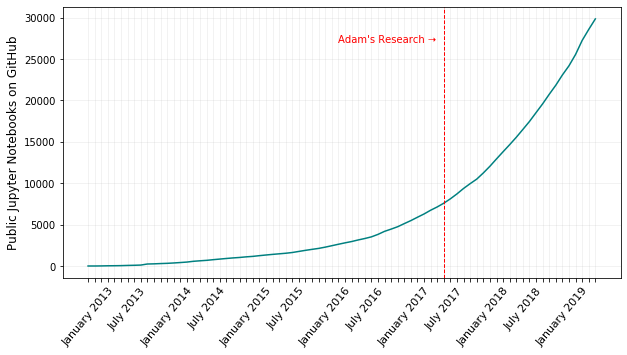

In [60]:
fig = plt.figure(figsize=(10, 5))
plt.plot(yearly_counts['order'][:-1],yearly_counts['cumulative'][:-1], color = 'teal')
plt.xticks(ticks = yearly_counts['order'][:-1],fontsize=11, labels = yearly_counts['labels'][:-1], rotation=50)
plt.ylabel('Public Jupyter Notebooks on GitHub', fontsize = 12)
# plt.title('Use of Notebooks over time', fontsize = 14)

plt.axvline(54, color = 'red', linewidth = 1, linestyle = '--')
plt.text(38, 27000, 'Adam\'s Research ➝', color = 'red')

plt.grid(alpha = 0.2)
plt.show()

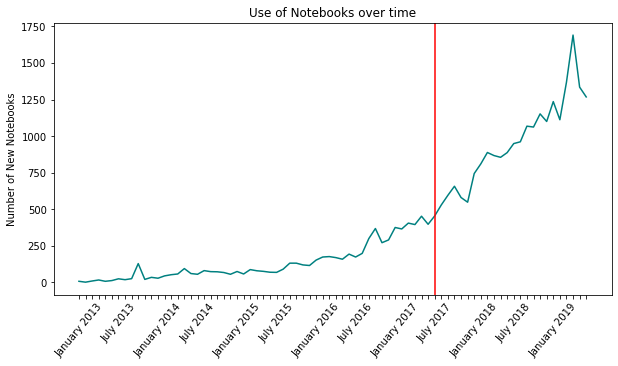

In [17]:
fig = plt.figure(figsize=(10, 5))
plt.plot(yearly_counts['order'][:-1],yearly_counts['count'][:-1], color = 'teal')
plt.xticks(ticks = yearly_counts['order'][:-1], labels = yearly_counts['labels'][:-1], rotation=50)
plt.ylabel('Number of New Notebooks')
plt.title('Use of Notebooks over time')
plt.axvline(54, color = 'red')
plt.show()

In [18]:
def get_avg_diff(yearly_counts):
    percent_diff = []
    diff = []
    prev = yearly_counts['count'][0]
    for v in yearly_counts['count'][1:]:
        if prev == 0 and v == 0:
            percent_diff.append(0)
            diff.append(0)
        elif prev != 0:
            percent_diff.append((v-prev)/prev)
            diff.append((v-prev))
        prev = v
    avg_percent_diff = pd.Series(percent_diff).mean()
    avg_diff = pd.Series(diff).mean()
    return avg_percent_diff, avg_diff

In [19]:
avg_percent_diff, avg_diff = get_avg_diff(yearly_counts)
print("On average, the number of notebooks on github increases by {0}% each month ({1} notebooks).".format(round(avg_percent_diff*100, 2), round(avg_diff,2)))


On average, the number of notebooks on github increases by 22.43% each month (5.5 notebooks).


In [20]:
before_18 = get_avg_diff(yearly_counts[yearly_counts.year < 2018].reset_index())[1]
after_18 = get_avg_diff(yearly_counts[yearly_counts.year >= 2018].reset_index())[1]
print("""Before 2018, the number of notebooks on github increased, on average, by {0} notebooks a month. 
Since 2018, that number has gone up more than {1} fold, with an average increase of {2} notebooks per month.""".format(
    round(before_18, 2),
    int(after_18//before_18),
    round(after_18, 2)
))

Before 2018, the number of notebooks on github increased, on average, by 9.17 notebooks a month. 
Since 2018, that number has gone up more than -2 fold, with an average increase of -17.11 notebooks per month.


## Is this increase exponential?

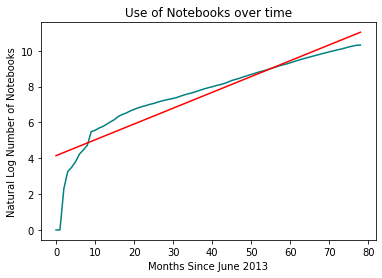

In [27]:
x = yearly_counts['order']
y = [math.log(y) if y != 0 else 0 for y in yearly_counts['cumulative']]

best_fit = np.polyfit(x, y, 1)

plt.plot(x, y, color = 'teal')
plt.plot(np.unique(x), np.poly1d(best_fit)(np.unique(x)), color = 'red')

plt.xlabel('Months Since June 2013')
plt.ylabel('Natural Log Number of Notebooks')
plt.title('Use of Notebooks over time')
plt.show()

In [28]:
# add constant to allow for an intercept
x = sm.add_constant(x)
# ordinary least squares simple regression
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     421.7
Date:                Fri, 26 Jul 2019   Prob (F-statistic):           5.69e-33
Time:                        11:53:31   Log-Likelihood:                -100.24
No. Observations:                  79   AIC:                             204.5
Df Residuals:                      77   BIC:                             209.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1457      0.194     21.337      0.000       3.759       4.533
order          0.0883      0.004     20.536      0.000       0.080       0.097
==============================================================================
Omnibus:                       76.480   Durbin-Watson:                   0.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              581.687
Skew:                          -3.014   Prob(JB):                    4.88e-127
Kurtosis:                      14.848   Cond. No.                         89.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Regression Assumptions**:
- Linearity: There is a leftover pattern in the residual plot, this condition is not met.
- Equal variance of residuals: There is a clear fan shape in the residual plot, so this condition may be violated. This is likely because there arent many observations in Jupyter's early years, so sample sizes are small between 0 and 40 months. Interpretations from these early months may not reliable.
- Normality of residuals: The quantile plot is not very linear, but the sample size is extremely large so this condition is satisfied by the central limit theorem.

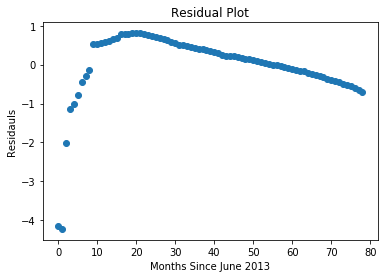

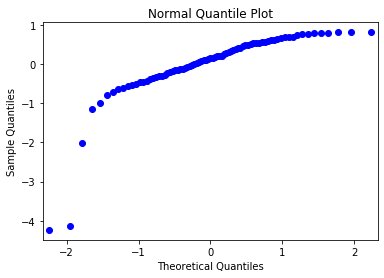

In [29]:
residuals = model.resid
plt.scatter(residuals.index, residuals)
plt.xlabel('Months Since June 2013')
plt.ylabel('Residauls')
plt.title('Residual Plot')
plt.show()

statsmodels.graphics.gofplots.qqplot(residuals)
plt.title('Normal Quantile Plot')
plt.show()

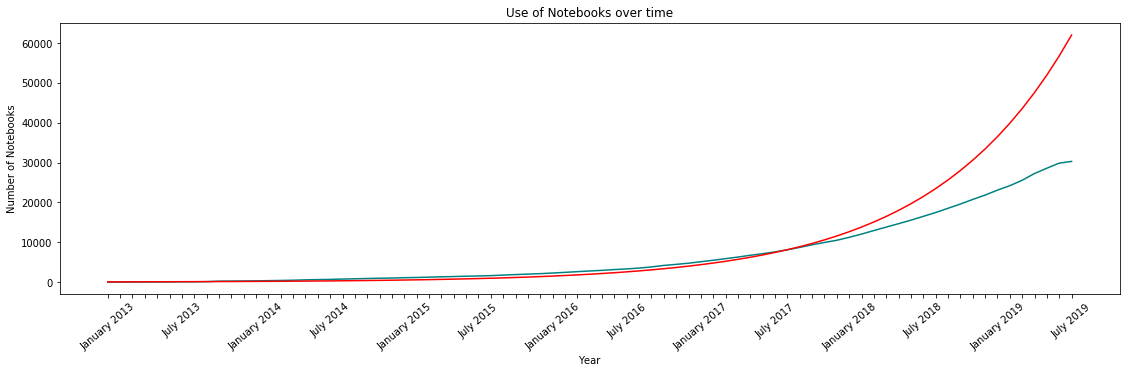

In [30]:
# exp_predictions = [3.068*(1.0897**o) for o in yearly_counts['order']]
exp_predictions = [math.exp(p) for p in predictions]

fig = plt.figure(figsize=(19, 5))
plt.plot(yearly_counts['order'],yearly_counts['cumulative'], color = 'teal')
plt.plot(yearly_counts['order'], exp_predictions, color = 'red')
plt.xlabel('Year')
plt.xticks(ticks = yearly_counts['order'], labels = yearly_counts['labels'], rotation=40)
plt.ylabel('Number of Notebooks')
plt.title('Use of Notebooks over time')
plt.show()

In [16]:
percent_diff = []
prev = exp_predictions[0]
for v in exp_predictions[1:]:
    if prev == 0 and v == 0:
        percent_diff.append(0)
    elif prev != 0:
        percent_diff.append((v-prev)/prev)
    prev = v
exp_avg_diff = pd.Series(percent_diff).mean()

avg_percent_diff, avg_diff = get_avg_diff(yearly_counts)

print("This model predicts that on average, the number of notebooks increases by {0}% each month.".format(round(exp_avg_diff*100, 2)))
print("Compare this to our original estimate of a {0}% each month.".format(round(avg_percent_diff*100, 2)))

This model predicts that on average, the number of notebooks increases by 8.84% each month.
Compare this to our original estimate of a 18.54% each month.


- let m = months since June 2013
- log(notebooks) = 1.1211 + 0.0859*m
- notebooks = $e^{1.1211 + 0.0859*m} = e^{1.1211}*e^{0.0859*m} = 3.068*1.0897^{m}$

For each additional month since June 2013, we expect a 8.97% increase in number of notebooks.

This doesnt seem to fit the more recent patterns (since July 2018) as well as it fits the early patterns (before July 2018). The number of notebooks on github fell below what was expected September 2018 through April 2019, and has recently spiked, and this model does not represent that well. The difference between the models average increase per month and our original estimate from the data is especially concerning.

## Estimate the rest of 2019

In [17]:
till_june_2019_py = over_time[np.logical_and(
    np.logical_and(over_time.year == 2019, over_time.month < 6), 
    over_time.lang_name=='python')
]
till_june_2018_py = over_time[np.logical_and(
    np.logical_and(over_time.year == 2018, over_time.month < 6),
    over_time.lang_name=='python')
]
print("{0} Python notebooks were written between January and May of 2018. This year, {1} have been written between January and May."\
      .format(len(till_june_2018_py), len(till_june_2019_py)))

increase = (len(till_june_2019_py) - len(till_june_2018_py))/len(till_june_2018_py)
print("This is a {0}% increase.".format(round(100*(increase), 2)))

total_2018 = len(over_time[over_time.year == 2018])
estimate_2019 = total_2018*(1+increase)

print("This estimates that a total of {0} Python notebooks will be created in the year 2019.".format(round(estimate_2019)))

6134 Python notebooks were written between January and May of 2018. This year, 13657 have been written between January and May.
This is a 122.64% increase.
This estimates that a total of 43589 Python notebooks will be created in the year 2019.


In [18]:
next_months = [(6+i, 3.068*(1.0897**(len(predictions)+i))) for i in range(7)]
next_months

[(6, 2717.0928282554155),
 (7, 2960.8160549499257),
 (8, 3226.4012550789344),
 (9, 3515.8094476595143),
 (10, 3831.1775551145724),
 (11, 4174.834181808349),
 (12, 4549.316807916557)]

<center> <a href = Questions.ipynb>Table of Contents &lt;</a> | <a href = 2_Languages.ipynb>&gt; Language Use</a> <center>